## Семинар 8: "Снижение размерности"

ФИО: Лысухин Даниил

In [81]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен сниению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [3]:
X = fetch_olivetti_faces()['data']

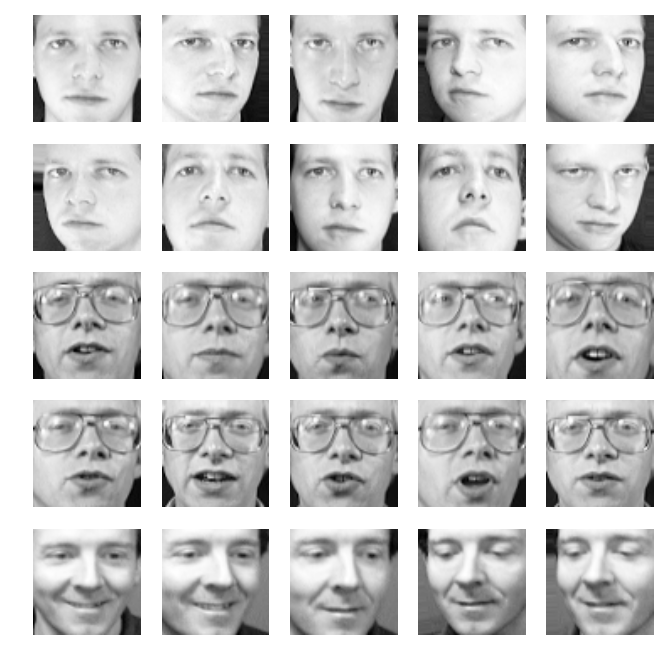

In [4]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [5]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

In [328]:
pca = PCA(n_components=25)

In [329]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [330]:
components = pca.components_
components.shape

(25, 4096)

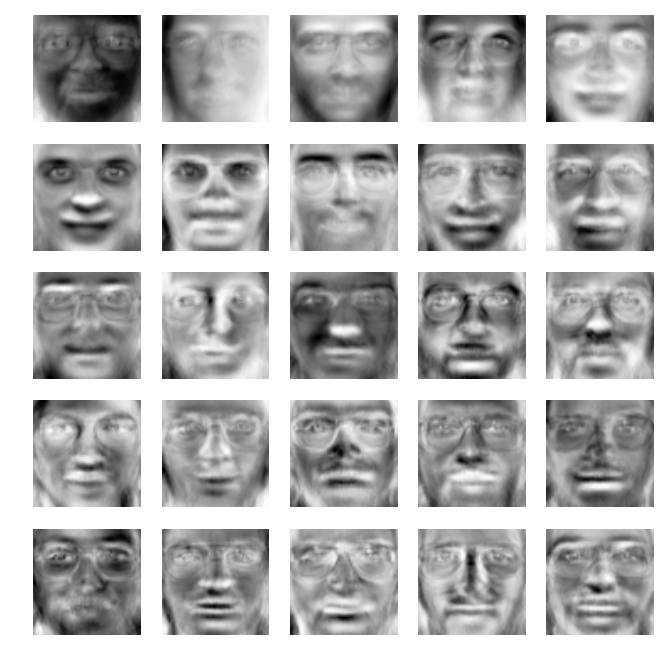

In [320]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

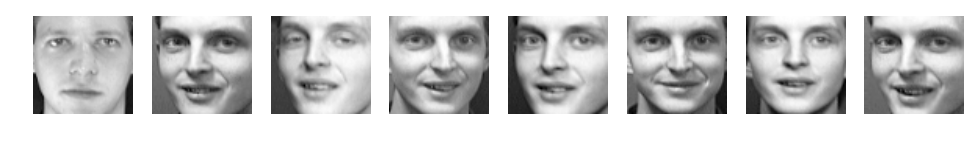

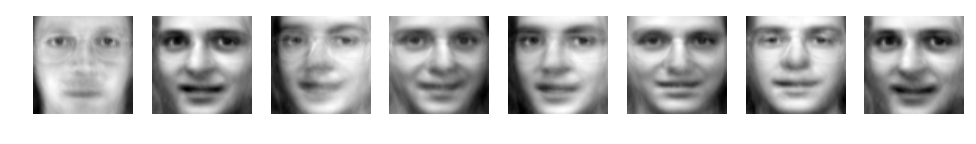

In [341]:
plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X[-i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(pca.inverse_transform(pca.transform(X[-i].reshape((1,-1)))).reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>
Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

In [10]:
import tqdm

In [11]:
n_components_range = range(0, 401, 5)

In [12]:
errors = []
for n_components in tqdm.tqdm_notebook(n_components_range):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    error = np.linalg.norm(X - pca.inverse_transform(pca.transform(X)))
    errors.append(error)

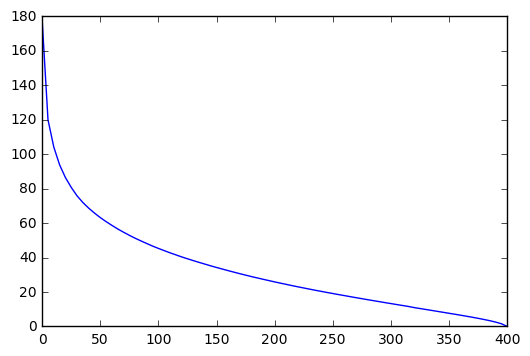

In [13]:
plt.plot(n_components_range, errors)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [19]:
pca_2comp = PCA(n_components=2)
pca_2comp.fit(X)
X_2d = pca_2comp.transform(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
X_2d.shape

(400, 2)

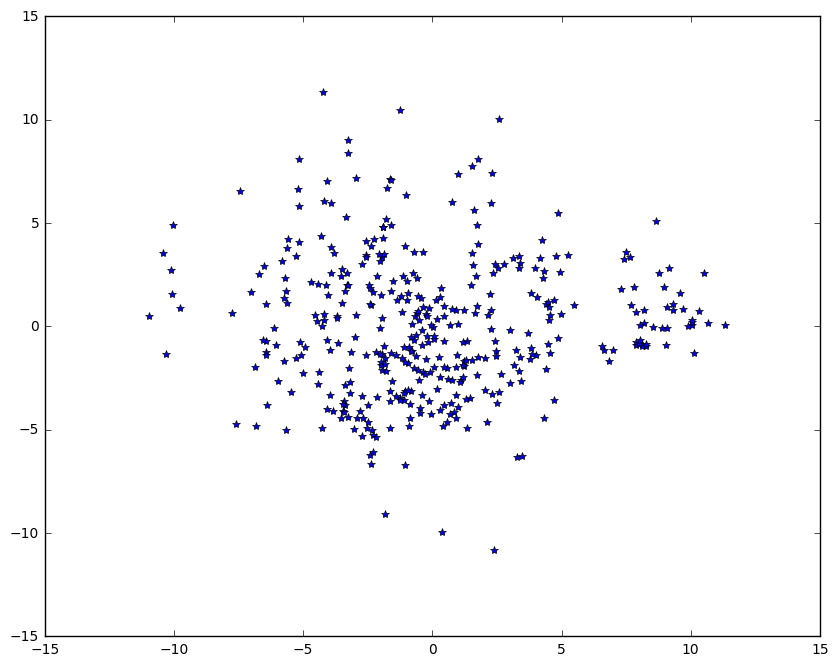

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(X_2d[:, 0], X_2d[:, 1], "*")

In [77]:
def plot_dataset(dataset, x, y, margin=50, frame=2000., imsize=64):
    x1 = (x - x.min()) * (frame / (x.max() - x.min())) + margin
    y1 = (y - y.min()) * (frame / (y.max() - y.min())) + margin
    image = np.zeros((int(y1.max() + margin + imsize), int(x1.max() + margin + imsize))) + 1
    print "Image size is %dx%d" % image.shape
    for k in xrange(dataset.shape[0]):
        image[int(y1[k]): int(y1[k]) + 64, int(x1[k]): int(x1[k]) + 64] = dataset[k]
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

Image size is 2164x2164


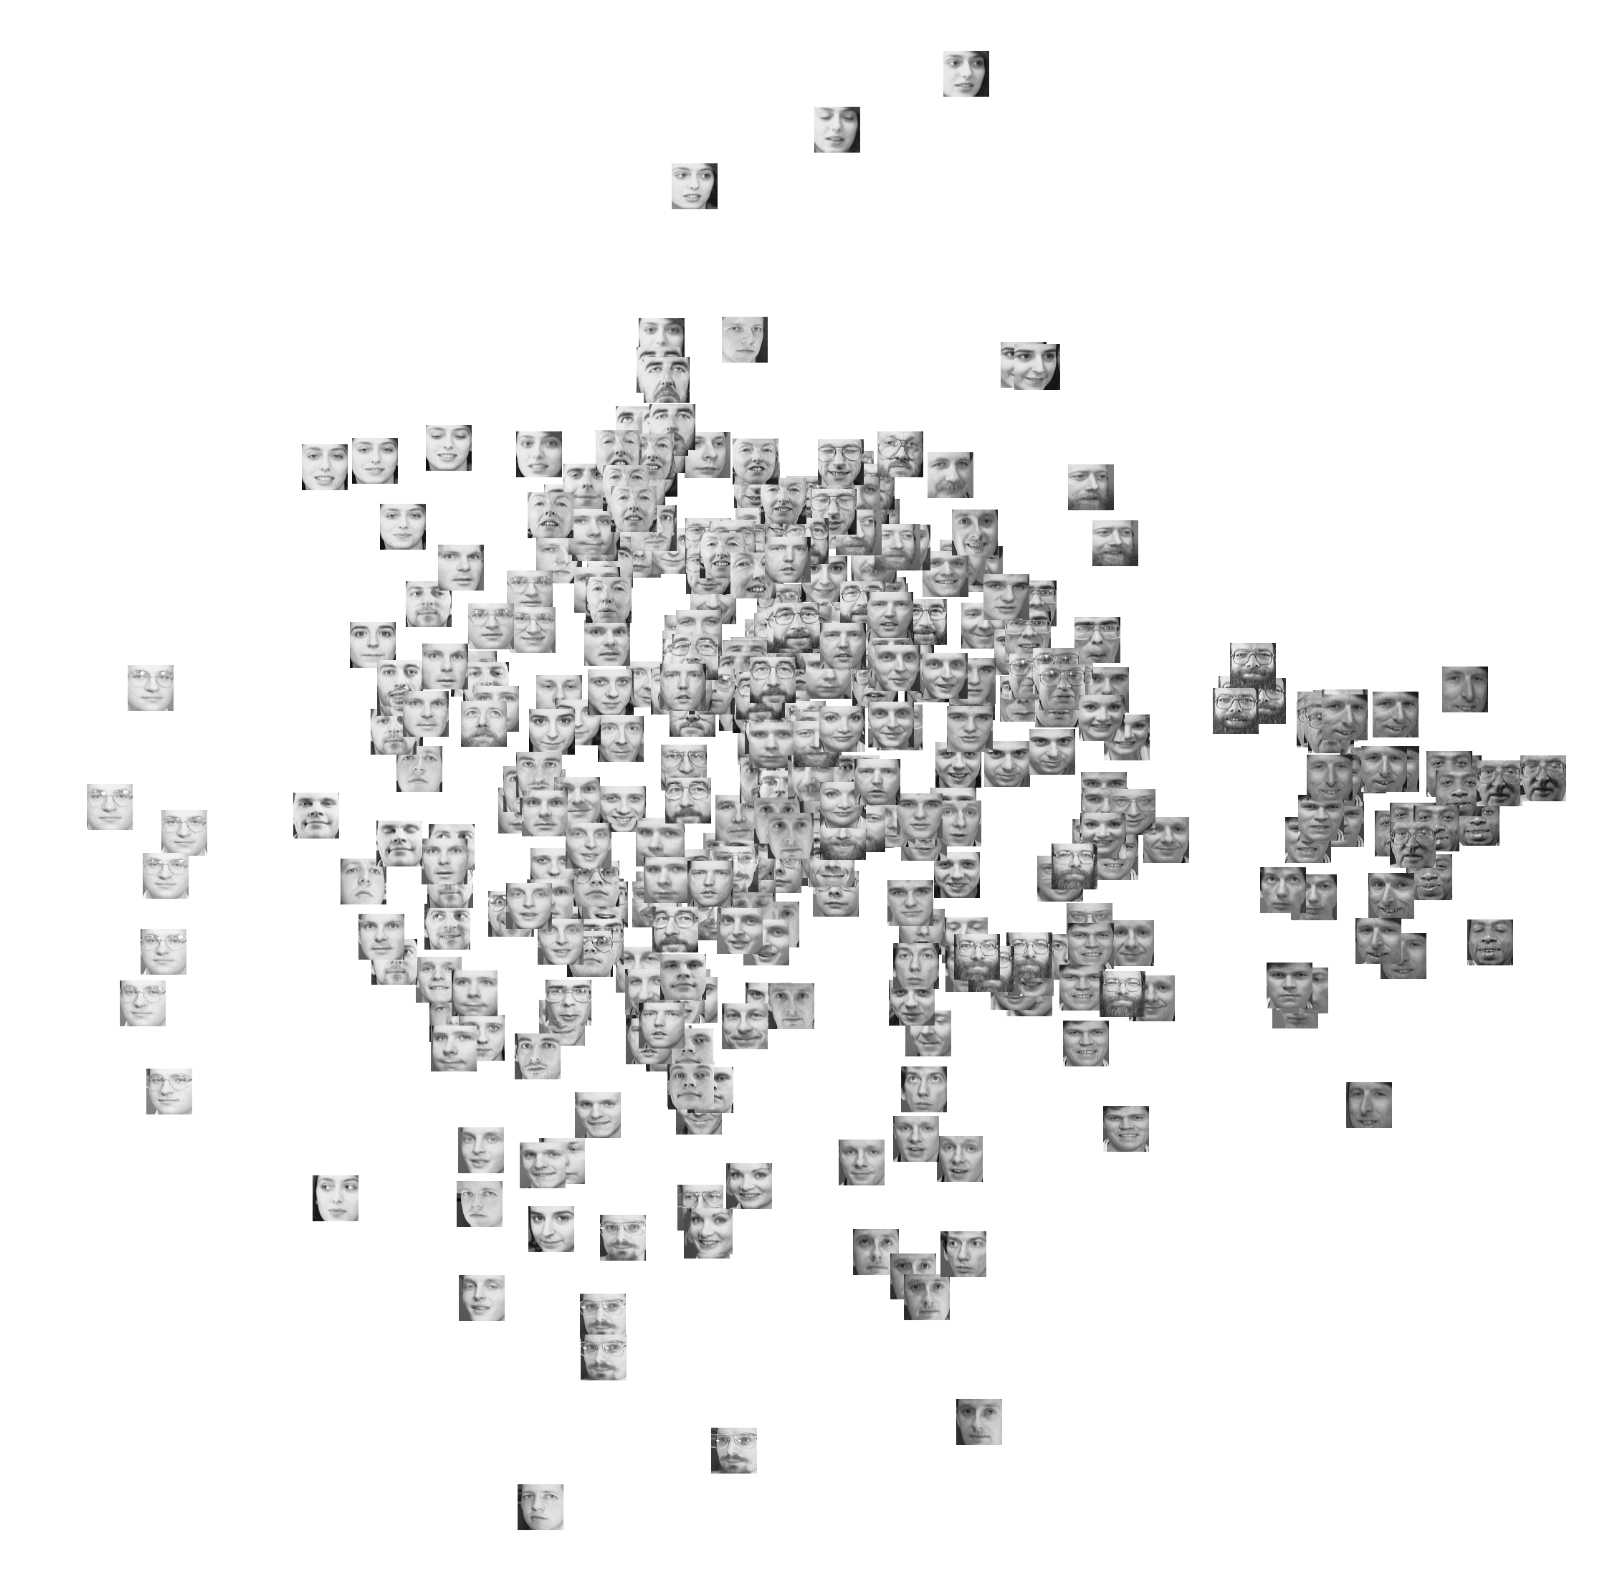

In [78]:
plot_dataset(X.reshape((400, 64, 64)), X_2d[:, 0], X_2d[:, 1])

In [305]:
X_centered = (X - X.mean(axis=0)) / X.std(axis=0)
X_centered.shape

(400, 4096)

In [306]:
pca_2comp = PCA(n_components=2)
pca_2comp.fit(X_centered)
X_2d_centered = pca_2comp.transform(X_centered)

Image size is 2164x2164


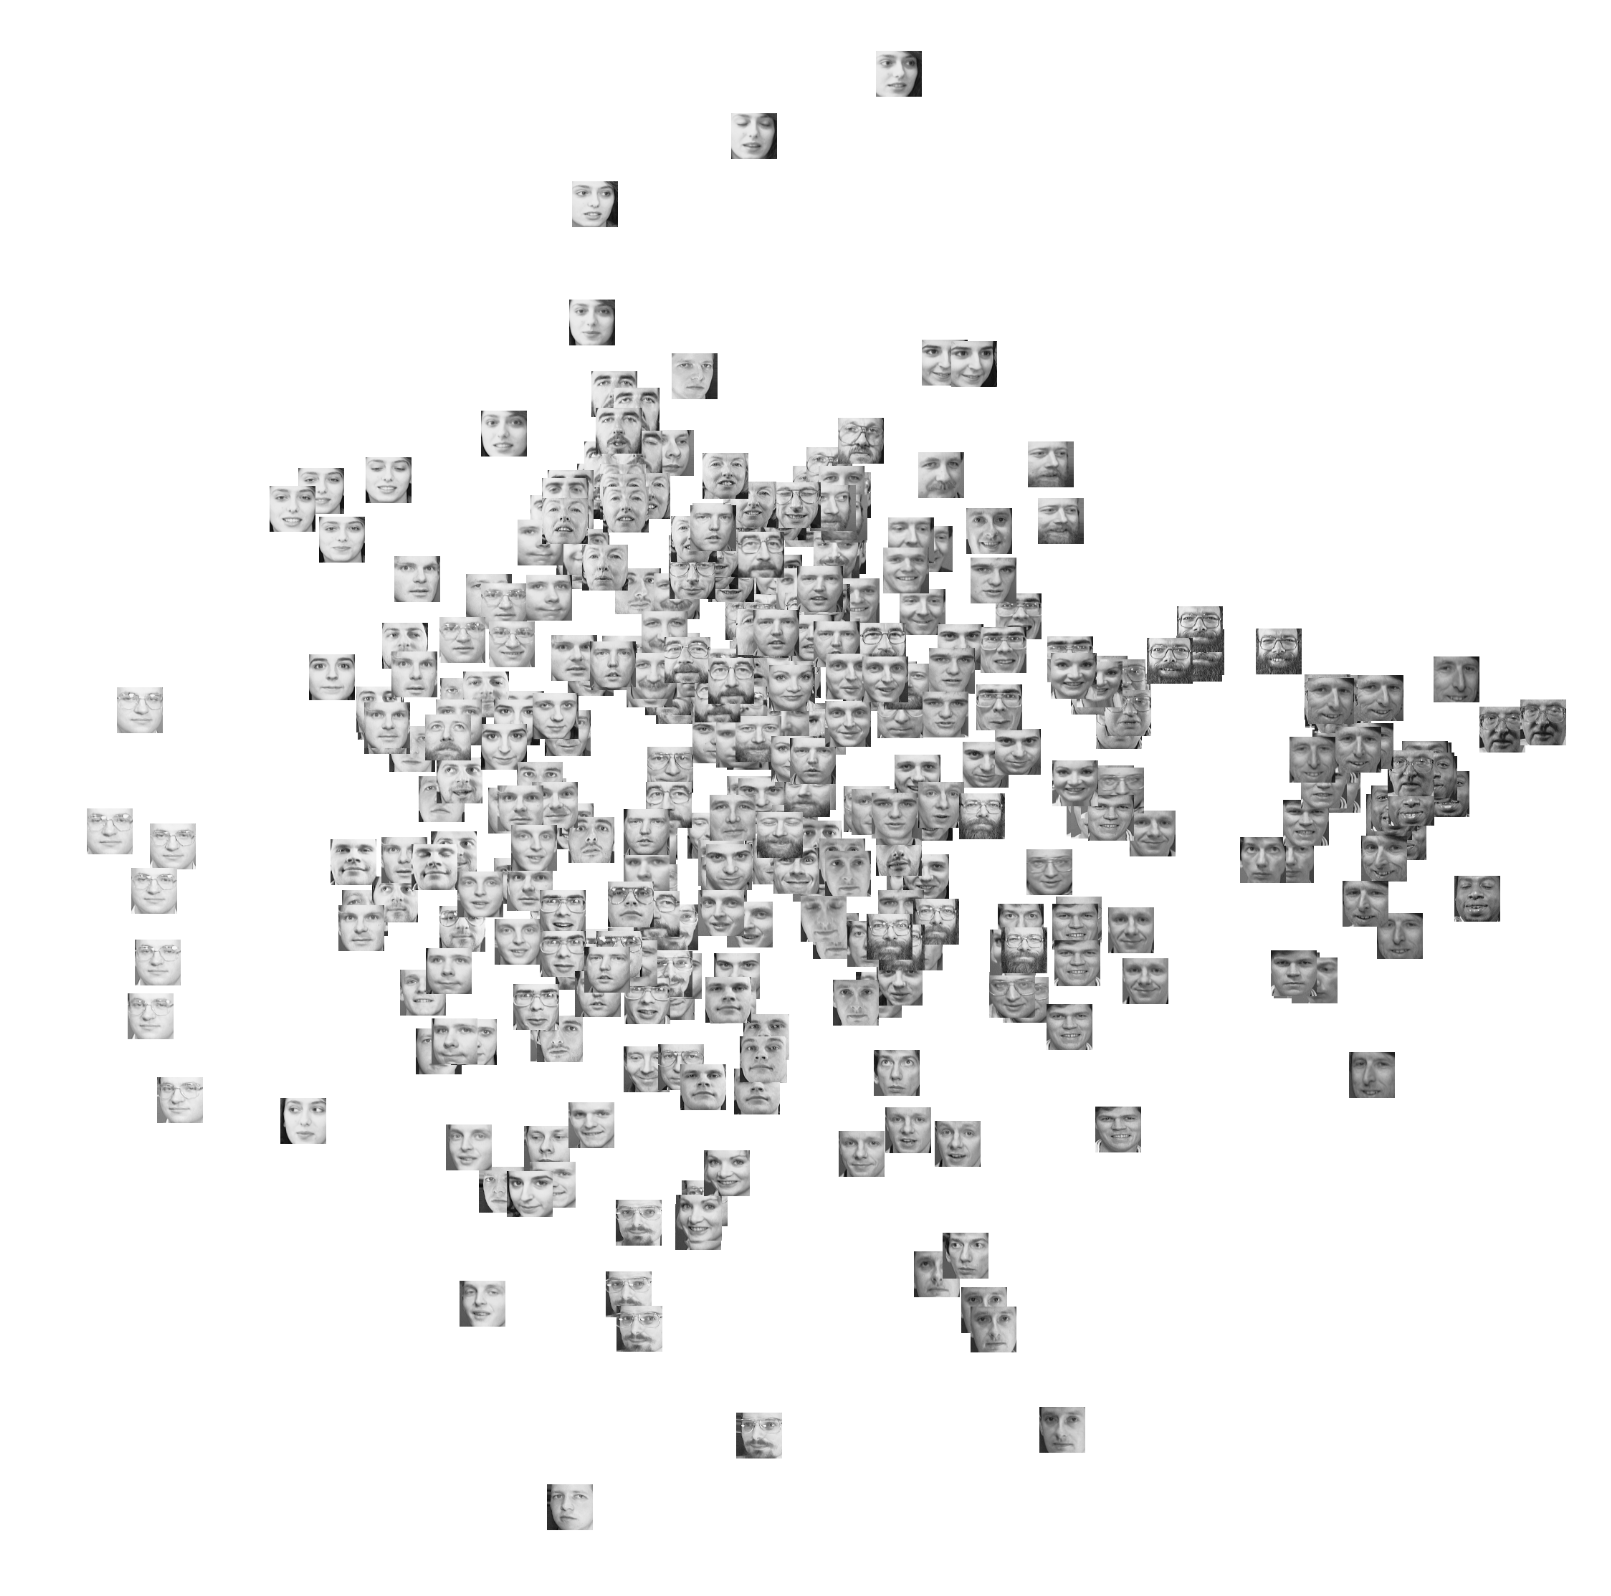

In [307]:
plot_dataset(X.reshape((400, 64, 64)), X_2d_centered[:, 0], X_2d_centered[:, 1])

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [208]:
class MyAutoEncoder(nn.Module):
    def __init__(self, dim=10):
        super(MyAutoEncoder, self).__init__()
        self.encoding_layers = nn.Sequential(nn.Linear(64 * 64, 200),
                                             nn.Sigmoid(),
                                             nn.Linear(200, dim), 
                                             nn.Sigmoid())
        
        self.decoding_layers = nn.Sequential(nn.Linear(dim, 200),
                                             nn.Sigmoid(),
                                             nn.Linear(200, 64 * 64),
                                             nn.Sigmoid())
        
    def forward(self, x):
        x = self.encoding_layers(x)
        x = self.decoding_layers(x)
        return x
    
    def encode(self, x):
        return self.encoding_layers(x)
    
    def decode(self, x):
        return self.decoding_layers(x)

In [240]:
def MSE(input, target):
    return torch.norm(input-target)

In [241]:
def train_autoencoder(autoencoder, X, n_epochs=40, batch_size=10, lr=1e-4, each=10):

    dtype = torch.FloatTensor

#     loss_fn = torch.nn.MSELoss()
    loss_fn = MSE
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-6)
        
    n_batches = X.shape[0] / batch_size
    loss_on_epochs = []
    
    for epoch in tqdm.tqdm_notebook(xrange(n_epochs), leave="False"):
        X = shuffle(X)
        losses=[]
        for batch in xrange(n_batches):
            x = Variable(torch.from_numpy(X[batch * batch_size: (batch + 1) * batch_size]).type(dtype), requires_grad = False)
            x_restored = autoencoder.forward(x)

            loss = loss_fn(input = x_restored, target = x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.data[0])
            
        loss_on_epochs.append(np.mean(losses))
        if epoch % each == 0:
            print ("epoch #%d, train loss %.4f" % (epoch, loss_on_epochs[-1]))
        
    return autoencoder, loss_on_epochs

In [332]:
# ae = MyAutoEncoder(dim=10)
ae, loss = train_autoencoder(ae, X_centered, n_epochs=200)

epoch #0, train loss 183.3161
epoch #10, train loss 183.0657
epoch #20, train loss 182.4863
epoch #30, train loss 182.3758
epoch #40, train loss 182.1971
epoch #50, train loss 182.0513
epoch #60, train loss 181.6518
epoch #70, train loss 181.5829
epoch #80, train loss 181.4805
epoch #90, train loss 181.0621
epoch #100, train loss 180.8933
epoch #110, train loss 180.5403
epoch #120, train loss 180.1568
epoch #130, train loss 180.0461
epoch #140, train loss 179.6723
epoch #150, train loss 179.3080
epoch #160, train loss 179.1122
epoch #170, train loss 178.9154
epoch #180, train loss 178.5226
epoch #190, train loss 178.4490



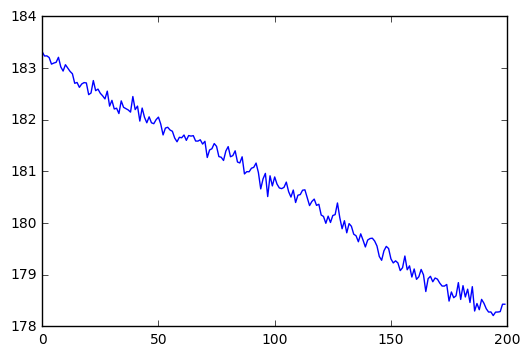

In [333]:
plt.plot(loss)

In [334]:
X_restored_centered = ae.decode(ae.encode(Variable(torch.from_numpy(X_centered.reshape(400, 4096)).type(torch.FloatTensor), requires_grad=False, volatile=True))).data.numpy()
X_restored = X_restored_centered * X.std(axis=0) + X.mean(axis=0)

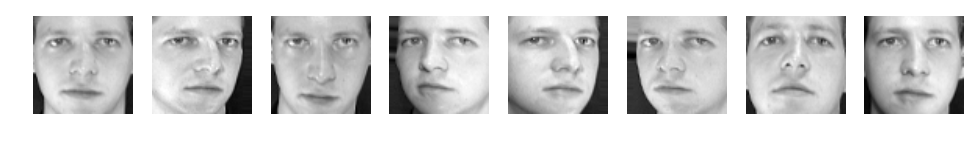

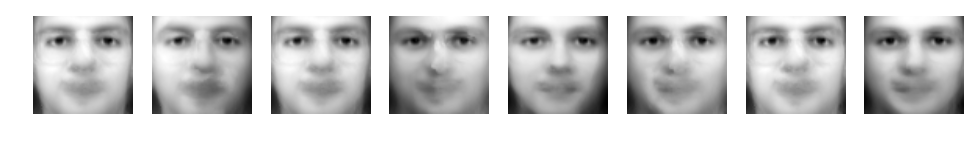

In [336]:
plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X_restored[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

<i> 2.2 Какое качество восстановления удалось получить?</i>

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [342]:
n_components_log_range = np.logspace(3, 8, num=6, base=2.)
n_components_log_range = [int(j) for j in n_components_log_range]
n_components_log_range

[8, 16, 32, 64, 128, 256]

In [278]:
losses = []
for n_components in n_components_log_range:
    print "=" * 75
    print "n_components: %d" % n_components
    ae = MyAutoEncoder(dim=n_components)
    ae, loss = train_autoencoder(ae, X, n_epochs=200)
    losses.append(loss[-1])

n_components: 8
epoch #0, train loss 34.8075

epoch #10, train loss 28.0434
epoch #20, train loss 27.6164
epoch #30, train loss 26.9487
epoch #40, train loss 26.5478
epoch #50, train loss 26.1672
epoch #60, train loss 25.6594
epoch #70, train loss 24.9139
epoch #80, train loss 24.0951
epoch #90, train loss 23.4639
epoch #100, train loss 23.0344
epoch #110, train loss 22.7182
epoch #120, train loss 22.4675
epoch #130, train loss 22.2257
epoch #140, train loss 21.9557
epoch #150, train loss 21.6445
epoch #160, train loss 21.4304
epoch #170, train loss 21.2097
epoch #180, train loss 21.1116
epoch #190, train loss 21.0536
n_components: 16
epoch #0, train loss 34.6666
epoch #10, train loss 28.0301
epoch #20, train loss 27.5277
epoch #30, train loss 26.8039
epoch #40, train loss 26.0287
epoch #50, train loss 25.2597
epoch #60, train loss 24.3951
epoch #70, train loss 23.6523
epoch #80, train loss 23.1651
epoch #90, train loss 22.9101
epoch #100, train loss 22.7367
epoch #110, train loss 22.5

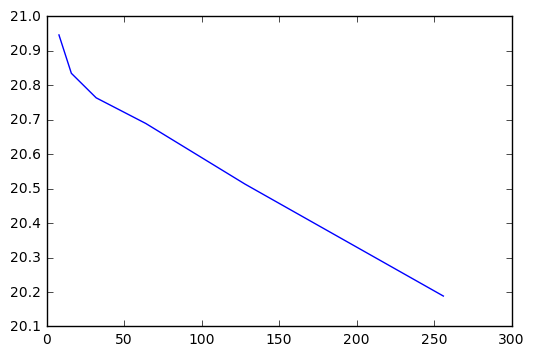

In [279]:
plt.plot(n_components_log_range, losses)

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

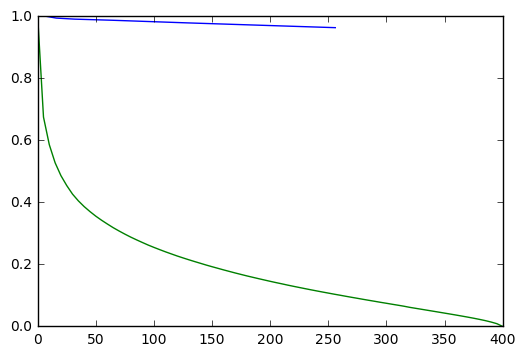

In [280]:
plt.plot(n_components_log_range, losses / max(losses))
plt.plot(range(0, 401, 5), errors / max(errors))

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [282]:
ae = MyAutoEncoder(dim=2)
ae, losses = train_autoencoder(ae, X, n_epochs=200, each=10)

epoch #0, train loss 35.2458
epoch #10, train loss 28.0190
epoch #20, train loss 27.6471
epoch #30, train loss 27.1562
epoch #40, train loss 26.7252
epoch #50, train loss 26.3601
epoch #60, train loss 26.0291
epoch #70, train loss 25.8446
epoch #80, train loss 25.5686
epoch #90, train loss 25.4452
epoch #100, train loss 25.1529
epoch #110, train loss 24.9739
epoch #120, train loss 24.6971
epoch #130, train loss 24.3993
epoch #140, train loss 24.0558
epoch #150, train loss 23.7416
epoch #160, train loss 23.5049
epoch #170, train loss 23.3139
epoch #180, train loss 23.1374
epoch #190, train loss 23.0109



In [283]:
X_2d = ae.encode(Variable(torch.from_numpy(X).type(torch.FloatTensor), requires_grad=False, volatile=True))

Image size is 2164x2164


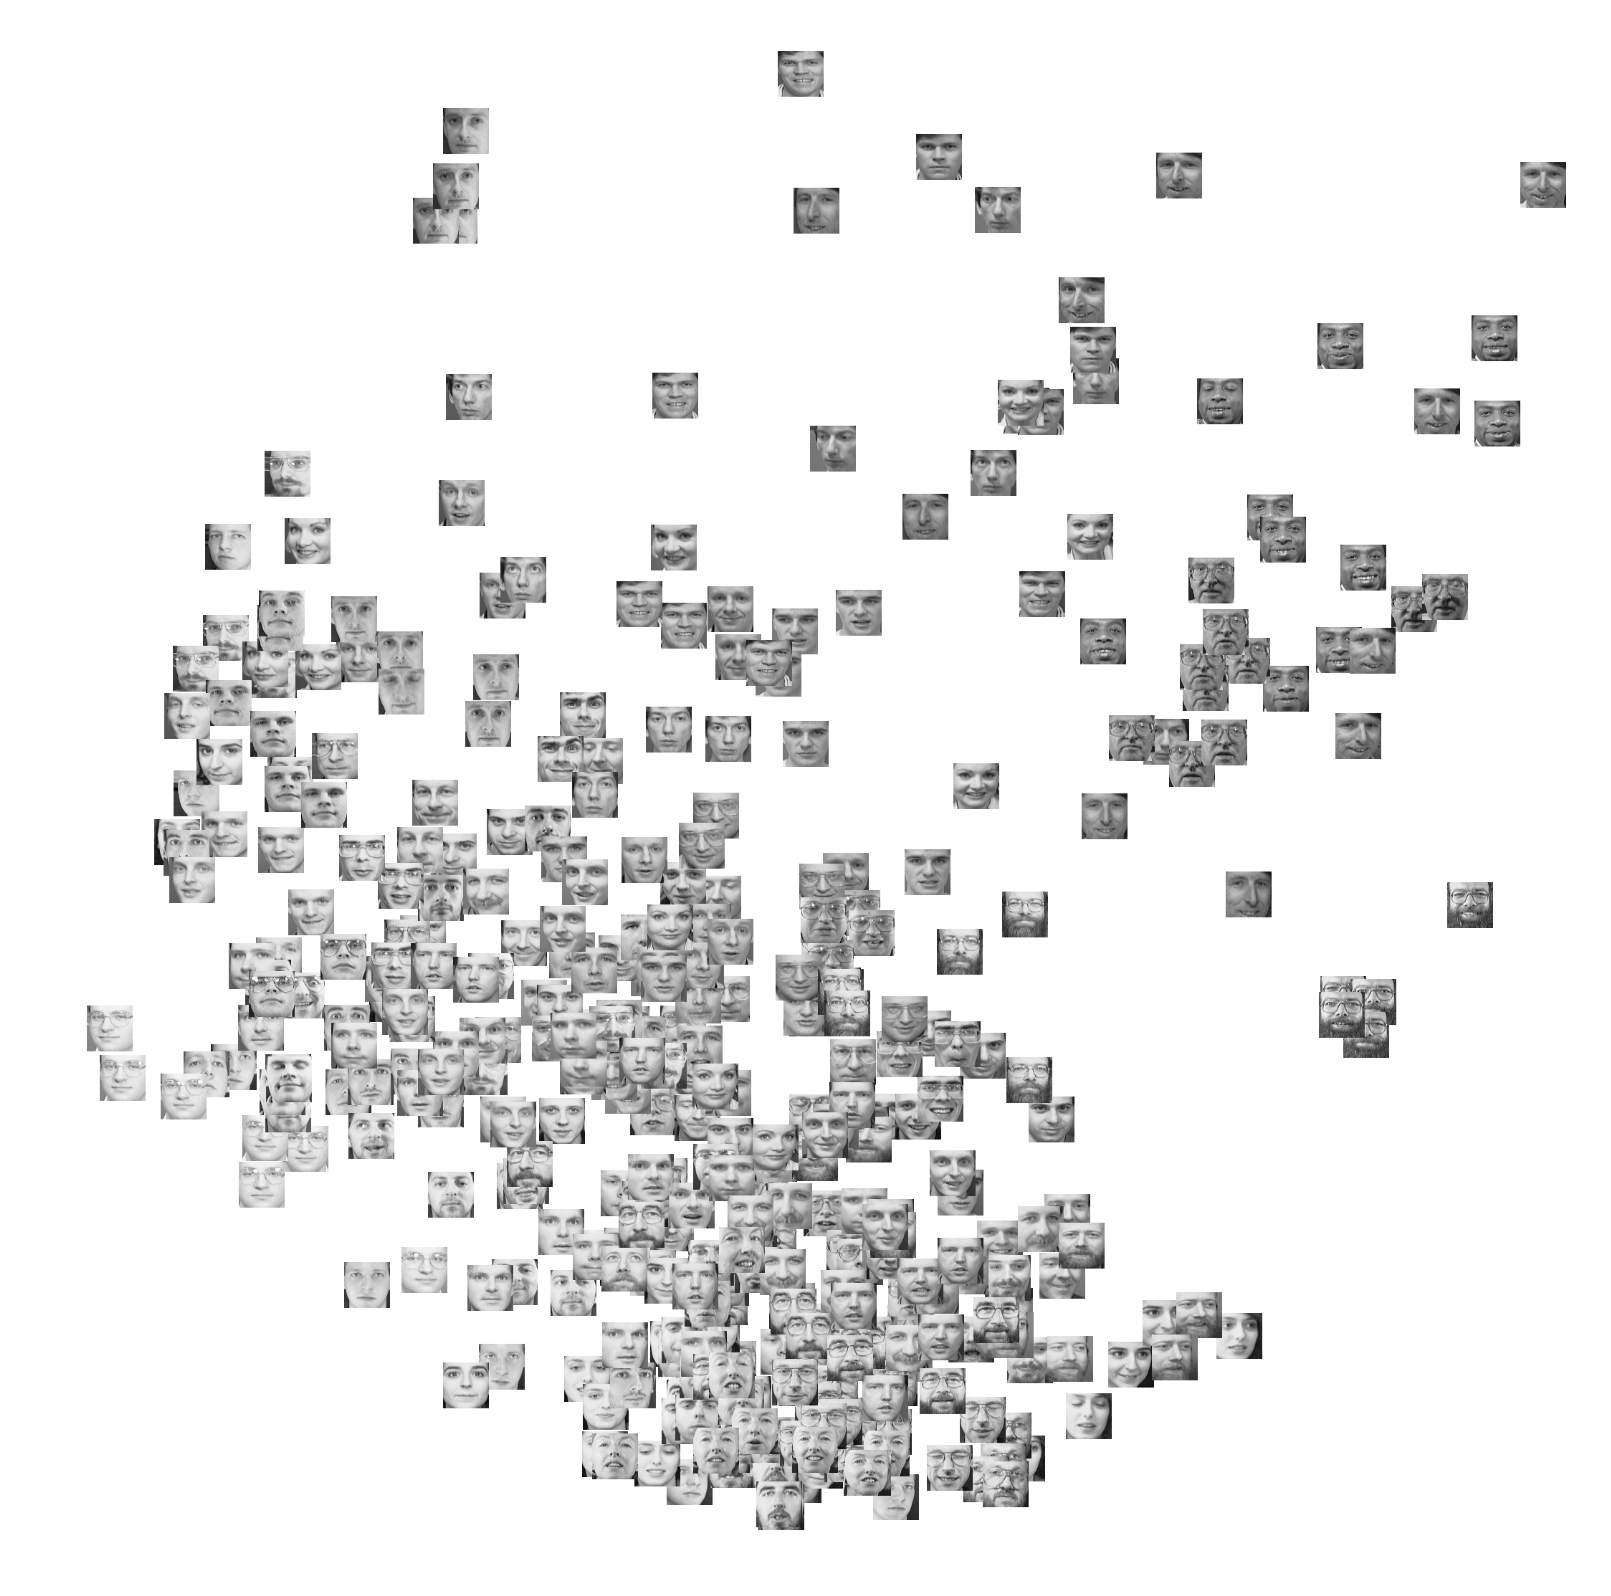

In [285]:
plot_dataset(X.reshape((400, 64, 64)), X_2d.data.numpy()[:, 0], X_2d.data.numpy()[:, 1])

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: